# ALUNOS: 

- Aluno 1:Vinicius Fonseca Navarro
- Aluno 2:Arthur de Barros Marcondes Machado Rosisca


# CIÊNCIA DE DADOS

## Etapas previstas para realizar Análise Exploratória dos Dados:
- Importar as bibliotecas necessárias 
- Separar as variáveis de input (independentes) e o target (alvo, objetivo)
- Separar a base em treino e teste
- Definir os algoritmos a serem testados
- Criar o classificador
- Treinar o modelo com a base de treino
- Avaliar o r2
- Predizer o modelo com a base de teste
- Avaliar os resultados obtidos
- Comparar os modelos
- Apresentar os resultados

## Análise de Perfil de risco de Beneficiários

O desafio consiste na **análise de perfil de risco de beneficiários com predição, analise de custo evitado e alertas de possíveis candidatos a doenças crônicas**, segundo a Portaria nº 483, de 1º de abril de 2014, as doenças crônicas são aquelas que apresentam início gradual, com duração longa ou incerta, que, em geral, apresentam múltiplas causas e cujo tratamento envolva mudanças de estilo de vida, em um processo de cuidado contínuo. Segundo a OMS as principais doenças crônicas não transmissíveis, (DCNT), um exemplo são:
- Doenças cerebrovasculares
- Doenças cardiovasculares
- Diabetes mellitus
- Doenças respiratórias crônicas (asma)
- Neoplasias (câncer)
- Obesidade
- Hipertensão

Na Unimed Ponta Grossa, temos o programa de acompanhamento linha de cuidado, em que os beneficiários identificados com as DCNT são acompanhados.

Para as análises e ETLs serão disponibilizadas informações referentes a utilização do plano de saúde por todos os beneficiários, procedimentos executados, dados do perfil de usuário, entradas em pronto atendimento e internação (em uma base separada para ser relacionada por id de pessoa). Também serão indicados os pacientes que já possuem diagnóstico de DCNT e já são acompanhados pela equipe de linha e cuidado e o tempo de acompanhamento. 

O **objetivo** é construir um modelo capaz calcular o custo evitado dos pacientes que estão no programa, identificar pacientes com maior probabilidade de desenvolver DCTNs ou que já possam estar com alguma DCNTs e não fazem parte da nossa linha de cuidado, com base em seus perfis e históricos médicos.

Resultados Esperados:
- Tratamento das informações
- Relacionamento entre o Datasets
- Identificação de padrões para cada grupo
- Alertas de possíveis pacientes com DCNTs
- Predição de possíveis casos:
- Resultado de custo Evitado (custo do paciente antes de entrar no programa e após a entrada no programa)
- Predição de custo evitado de pacientes que ainda não fazem parte do programa
Bônus: outras analises não indicadas acima
**Obs: na analise de custo evitado, levar em conta a correção monetária dos anos anteriores
 
Dados Gerais
- ID de usuário
- Data de nascimento
- Sexo
- Peso
- Número de Gestações
- Grau de dependência (Se Titular)
- Contratante
- Tipo de Plano
- Procedimentos Realizados
- Data do procedimento
- Especialidade do executante
- Especialidade do solicitante
- Paciente faz parte da linha de cuidado
- Programa que o paciente faz parte

Dados de PA e Internação (somente Beneficiários):
- ID do atendimento
- Data/hora da entrada
- Procedimento principal do atendimento
- CID
- Queixa
- Observação
- Clínica (tipo de atendimento)
- Especialidade Médico Responsável
- Classificação de Risco (Manchester)
- Data/hora da Internação
- Motivo da Alta
- Data da alta

# Importar e visualizar a base

### Coleta e Descrição dos Dados

In [1]:
# Importar as bibliotecas necessárias para solucionar o problema
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Bibliotecas de Modelagem
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import r2_score, mean_absolute_error

print("Bibliotecas importadas com sucesso!")

Bibliotecas importadas com sucesso!


In [2]:
import pandas as pd
import numpy as np

# --- PASSO 1: Carregar as tabelas que se conectam ---
print("Carregando fontes de dados confiáveis...")

path_plano = 'Dados/Plano de Saúde/'
path_cuidado = 'Dados/Linha de cuidado/'
nome_da_aba = 'Result 1'

try:
    # A tabela de custos e procedimentos (fonte principal)
    print("Carregando arquivo grande de custos...")
    df_custos = pd.read_excel(path_plano + 'beneficiario_custo_procedimento_plano_de_saude.xlsx')

    # O dicionário que mapeia PROCEDIMENTOS para linhas de cuidado
    df_programas = pd.read_excel(path_cuidado + 'procedimento_linha_cuidado.xlsx') #, sheet_name=nome_da_aba)

    # A tabela com as informações demográficas dos pacientes
    df_benef_info = pd.read_excel(path_plano + 'beneficiarios.xlsx', sheet_name=nome_da_aba)
    
    print("Dados carregados com sucesso!")

except Exception as e:
    print(f"ERRO ao carregar os arquivos. Verifique os nomes e caminhos. Detalhe: {e}")
    raise

# --- PASSO 2: Identificar PROCEDIMENTOS e PACIENTES com DCNT ---
print("\nIdentificando pacientes com DCNT via procedimentos...")

# IMPORTANTE: Verifique os valores reais na sua coluna 'ds_linha_cuidado' e ajuste a lista!
programas_dcnt_nomes = [
    'Diabetes', 'Hipertensão', 'Oncologia', 'Cardiologia',
    'Asma', 'Obesidade', 'Doenças Renais', 'Gestantes' # Ajuste esta lista se necessário
]

# Filtra o dicionário para obter apenas os procedimentos de DCNT
df_programas_dcnt = df_programas[df_programas['ds_linha_cuidado'].isin(programas_dcnt_nomes)]
ids_itens_dcnt = set(df_programas_dcnt['id_item'])
print(f"Encontrados {len(ids_itens_dcnt)} tipos de procedimentos mapeados para DCNT.")

# Marca cada procedimento na tabela de custos como DCNT ou não
df_custos['procedimento_eh_dcnt'] = df_custos['id_item'].apply(lambda x: 1 if x in ids_itens_dcnt else 0)

# Obtém a lista de IDs de beneficiários únicos que tiveram pelo menos um procedimento de DCNT
benef_com_dcnt_ids = set(df_custos[df_custos['procedimento_eh_dcnt'] == 1]['id_beneficiario'].unique())
print(f"Encontrados {len(benef_com_dcnt_ids)} beneficiários com histórico de procedimentos de DCNT.")


# --- PASSO 3: Construir o DataFrame agregado final ---
print("\nConstruindo o DataFrame agregado final...")
df_agg = df_custos.groupby('id_beneficiario').agg(
    custo_total=('vl_item', 'sum'),
    n_procedimentos=('id_item', 'count')
).reset_index()

# Merge com informações demográficas
df_final = pd.merge(df_agg, df_benef_info, on='id_beneficiario', how='left')

# Criar a flag 'tem_dcnt' final e precisa com base nos procedimentos
df_final['tem_dcnt'] = df_final['id_beneficiario'].apply(lambda x: 1 if x in benef_com_dcnt_ids else 0)

# Limpeza final
df_final.dropna(subset=['qt_idade', 'ds_sexo'], inplace=True)

print("\nDataFrame final pronto para modelagem!")
print("--- AMOSTRA DO DATAFRAME FINAL ---")
print(df_final.head())
print(f"\nShape final: {df_final.shape}")
print("\nDistribuição da variável alvo 'tem_dcnt' (espera-se algo em torno de 1-5%):")
print(df_final['tem_dcnt'].value_counts(normalize=True))

Carregando fontes de dados confiáveis...
Carregando arquivo grande de custos...
Dados carregados com sucesso!

Identificando pacientes com DCNT via procedimentos...
Encontrados 6 tipos de procedimentos mapeados para DCNT.
Encontrados 1814 beneficiários com histórico de procedimentos de DCNT.

Construindo o DataFrame agregado final...

DataFrame final pronto para modelagem!
--- AMOSTRA DO DATAFRAME FINAL ---
   id_beneficiario  custo_total  n_procedimentos  nr_contrato  id_plano  \
0           135984      1137.85               32     181305.0     157.0   
1           135988       125.00                1    1821046.0     246.0   
2           135989       567.66                6    1821046.0     251.0   
3           135990      2405.41               36     663020.0       8.0   
4           135991       125.00                1     663020.0       8.0   

                                            ds_plano ds_formacao_preco  \
0                             UNIPLAN BASICO + OPC 2  Pré-estabe

In [3]:
# Visualizar as bases
print("--- AMOSTRA DO DATAFRAME FINAL ---")
print(df_final.head())
print(f"\nShape final: {df_final.shape}")
print("\nDistribuição da variável alvo 'tem_dcnt':")
print(df_final['tem_dcnt'].value_counts(normalize=True))

--- AMOSTRA DO DATAFRAME FINAL ---
   id_beneficiario  custo_total  n_procedimentos  nr_contrato  id_plano  \
0           135984      1137.85               32     181305.0     157.0   
1           135988       125.00                1    1821046.0     246.0   
2           135989       567.66                6    1821046.0     251.0   
3           135990      2405.41               36     663020.0       8.0   
4           135991       125.00                1     663020.0       8.0   

                                            ds_plano ds_formacao_preco  \
0                             UNIPLAN BASICO + OPC 2  Pré-estabelecido   
1                                     UNIPLAN BASICO  Pré-estabelecido   
2                             UNIPLAN BASICO + OPC 2  Pré-estabelecido   
3  INDIVIDUAL/FAMILIAR AMBULATORIAL + HOSPITALAR ...  Pré-estabelecido   
4  INDIVIDUAL/FAMILIAR AMBULATORIAL + HOSPITALAR ...  Pré-estabelecido   

   id_familia  qt_idade    ds_sexo ds_estado_civil ds_parentesco  tem

## Visualizando um resumo das informações


In [4]:
# Verificando o domínio dos dados


# **Conclusão: identifique quais colunas (variáveis) seriam utilizadas em um modelo de aprendizagem de máquina**
## **Relevantes para Previsão** obtidas após a realização da análise exploratória


In [5]:
# Para a célula "Apresente as colunas a serem utilizadas"
features_usadas = ['qt_idade', 'ds_sexo', 'custo_total', 'n_procedimentos']
print("Features selecionadas para o modelo de classificação:", features_usadas)

# Para a célula "Apresente as colunas eliminadas"
colunas_todas = set(df_final.columns)
colunas_usadas_set = set(features_usadas)
colunas_usadas_set.add('tem_dcnt') # Adicionar o target
colunas_eliminadas = colunas_todas - colunas_usadas_set
print("\nColunas não utilizadas diretamente no modelo (algumas foram usadas no pré-processamento):")
print(sorted(list(colunas_eliminadas)))

Features selecionadas para o modelo de classificação: ['qt_idade', 'ds_sexo', 'custo_total', 'n_procedimentos']

Colunas não utilizadas diretamente no modelo (algumas foram usadas no pré-processamento):
['ds_estado_civil', 'ds_formacao_preco', 'ds_parentesco', 'ds_plano', 'id_beneficiario', 'id_familia', 'id_plano', 'nr_contrato']


# PROJETO FINAL DE CIÊNCIA DE DADOS

Resultados Esperados:
- Tratamento das informações
- Relacionamento entre o Datasets
- Identificação de padrões para cada grupo
- Alertas de possíveis pacientes com DCNTs
- Predição de possíveis casos:
- Resultado de custo Evitado (custo do paciente antes de entrar no programa e após a entrada no programa)
- Predição de custo evitado de pacientes que ainda não fazem parte do programa
Bônus: outras analises não indicadas acima
**Obs: na analise de custo evitado, levar em conta a correção monetária dos anos anteriores


## Aprendizado de Máquina

- Definir 3 algorítmos de aprendizado de máquina a ser testado no Desafio

In [6]:
# Definir as variáveis de input e a target
df_model = df_final.copy()
df_model['ds_sexo'] = df_model['ds_sexo'].apply(lambda x: 1 if x == 'Masculino' else 0)

features = ['qt_idade', 'ds_sexo', 'custo_total', 'n_procedimentos']
target = 'tem_dcnt'

X = df_model[features]
y = df_model[target]

print("Variáveis X (features) e y (target) definidas.")
print("Shape de X:", X.shape)
print("Shape de y:", y.shape)

Variáveis X (features) e y (target) definidas.
Shape de X: (33416, 4)
Shape de y: (33416,)


In [7]:
# Dividir a base de dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print("Dados divididos em treino e teste.")
print(f"Treino: {X_train.shape[0]} amostras")
print(f"Teste: {X_test.shape[0]} amostras")

Dados divididos em treino e teste.
Treino: 23391 amostras
Teste: 10025 amostras


## Treinar, Predizer e Avaliar os Modelos

### Primeiro algoritmo

In [8]:
# Criar o classificador
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1)

In [9]:
# Treinar o modelo
print("Treinando o Random Forest...")
rf_model.fit(X_train, y_train)
print("Treinamento concluído.")

Treinando o Random Forest...
Treinamento concluído.


In [10]:
# Predizer o modelo
rf_pred = rf_model.predict(X_test)


--- Resultados do Random Forest ---
Acurácia: 0.9822

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      9850
           1       0.48      0.19      0.28       175

    accuracy                           0.98     10025
   macro avg       0.73      0.60      0.63     10025
weighted avg       0.98      0.98      0.98     10025



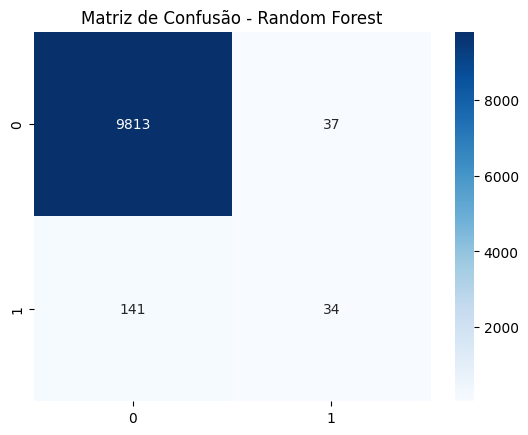

In [11]:
# Avaliar o modelo
print("\n--- Resultados do Random Forest ---")
rf_accuracy = accuracy_score(y_test, rf_pred)
print(f"Acurácia: {rf_accuracy:.4f}")
print("\nRelatório de Classificação:")
print(classification_report(y_test, rf_pred))
sns.heatmap(confusion_matrix(y_test, rf_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusão - Random Forest")
plt.show()

### Segundo algoritmo

In [12]:
# Criar o classificador
lr_model = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)

In [13]:
# Treinar o modelo
print("Treinando a Regressão Logística...")
lr_model.fit(X_train, y_train)
print("Treinamento concluído.")

Treinando a Regressão Logística...
Treinamento concluído.


In [14]:
# Predizer o modelo
lr_pred = lr_model.predict(X_test)

In [15]:
# Avaliar o modelo
print("\n--- Resultados da Regressão Logística ---")
lr_accuracy = accuracy_score(y_test, lr_pred)
print(f"Acurácia: {lr_accuracy:.4f}")
print("\nRelatório de Classificação:")
print(classification_report(y_test, lr_pred))


--- Resultados da Regressão Logística ---
Acurácia: 0.7575

Relatório de Classificação:
              precision    recall  f1-score   support

           0       1.00      0.76      0.86      9850
           1       0.06      0.85      0.11       175

    accuracy                           0.76     10025
   macro avg       0.53      0.80      0.48     10025
weighted avg       0.98      0.76      0.85     10025



### Terceiro algoritmo

In [16]:
# Criar o classificador
from sklearn.ensemble import GradientBoostingClassifier
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)

In [17]:
# Treinar o modelo
print("Treinando o Gradient Boosting... (Isso é bem mais rápido que o SVM)")
gb_model.fit(X_train, y_train)
print("Treinamento concluído.")

Treinando o Gradient Boosting... (Isso é bem mais rápido que o SVM)
Treinamento concluído.


In [18]:
# Predizer o modelo
gb_pred = gb_model.predict(X_test)

In [19]:
# Avaliar o modelo
print("\n--- Resultados do Gradient Boosting ---")
gb_accuracy = accuracy_score(y_test, gb_pred)
print(f"Acurácia: {gb_accuracy:.4f}")
print("\nRelatório de Classificação:")
print(classification_report(y_test, gb_pred))


--- Resultados do Gradient Boosting ---
Acurácia: 0.9821

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      9850
           1       0.47      0.19      0.27       175

    accuracy                           0.98     10025
   macro avg       0.73      0.59      0.63     10025
weighted avg       0.98      0.98      0.98     10025



## Comparar os resultados obtidos pelos algoritmos

--- Comparação dos Modelos de Classificação ---
                Modelo  Acurácia  Recall (classe 1)  Precision (classe 1)
0        Random Forest    0.9822             0.1943                0.4789
1  Logistic Regression    0.7575             0.8457                0.0580
2    Gradient Boosting    0.9821             0.1886                0.4714


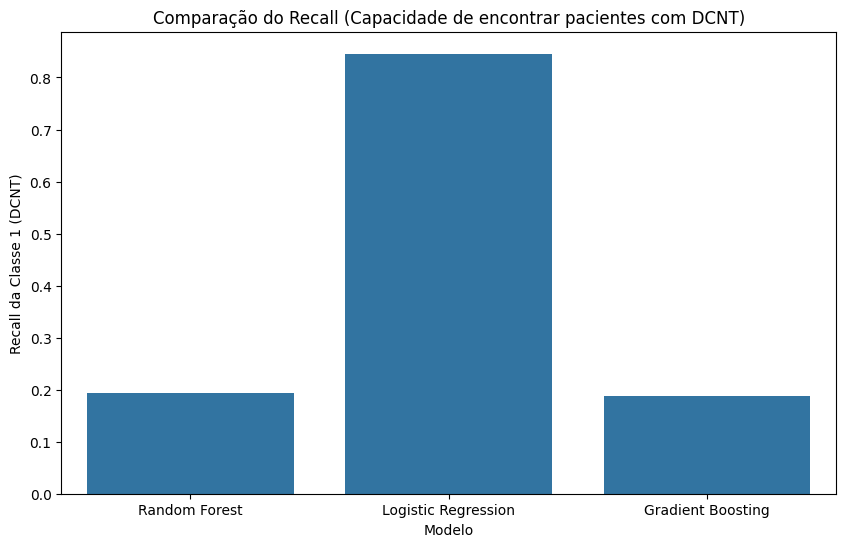

In [20]:
# comparar
# Célula '# comparar'

# Coletar as métricas para a tabela de comparação
rf_recall = recall_score(y_test, rf_pred, pos_label=1)
rf_precision = precision_score(y_test, rf_pred, pos_label=1)

lr_recall = recall_score(y_test, lr_pred, pos_label=1)
lr_precision = precision_score(y_test, lr_pred, pos_label=1)

gb_recall = recall_score(y_test, gb_pred, pos_label=1)
gb_precision = precision_score(y_test, gb_pred, pos_label=1)

# Criar o DataFrame de resultados
resultados = {
    'Modelo': ['Random Forest', 'Logistic Regression', 'Gradient Boosting'],
    'Acurácia': [rf_accuracy, lr_accuracy, gb_accuracy],
    'Recall (classe 1)': [rf_recall, lr_recall, gb_recall],
    'Precision (classe 1)': [rf_precision, lr_precision, gb_precision]
}

df_resultados = pd.DataFrame(resultados).round(4) # .round(4) para arredondar as casas decimais

print("--- Comparação dos Modelos de Classificação ---")
print(df_resultados)

# Visualizar o Recall, que é a nossa métrica mais importante
plt.figure(figsize=(10, 6))
sns.barplot(x='Modelo', y='Recall (classe 1)', data=df_resultados)
plt.title('Comparação do Recall (Capacidade de encontrar pacientes com DCNT)')
plt.ylabel('Recall da Classe 1 (DCNT)')
plt.show()

## Resultados obtidos

Apresentar de forma descritiva e em gráficos respondendo as questões solicitadas pela UNIMED

## Resultados Obtidos

Apresentação descritiva e gráfica dos resultados obtidos em resposta às questões solicitadas pela Unimed. A análise foi realizada em um universo de **33.416 beneficiários únicos**.

### Tratamento e Relacionamento entre os Datasets

O primeiro resultado alcançado foi a construção de uma base de dados unificada e coesa. Para isso, foi necessário um processo de ETL (Extração, Transformação e Carga) que uniu cinco fontes de dados distintas, incluindo informações demográficas, custos, procedimentos e o mapeamento de programas de Linha de Cuidado.

A abordagem final e mais robusta foi identificar os pacientes com DCNT com base nos procedimentos que realizaram, uma vez que a conexão entre os dados de custo e os de diagnóstico hospitalar se mostrou inconsistente. Este método resultou em uma base final com **1.814 beneficiários (5.4% do total)** identificados com um histórico de procedimentos de DCNT, que serviu como base para o treinamento dos modelos.

### Identificação de Padrões (Análise Exploratória)

A análise exploratória dos dados permitiu identificar padrões-chave sobre os beneficiários e seus custos, que foram fundamentais para a modelagem.

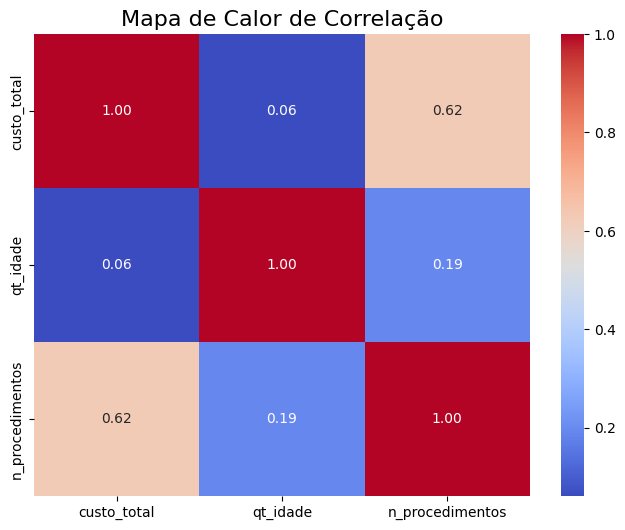

In [21]:
# Gráfico de Correlação entre as principais variáveis numéricas
plt.figure(figsize=(8, 6))
# Selecionando apenas colunas numéricas para correlação
numeric_cols = df_final[['custo_total', 'qt_idade', 'n_procedimentos']]
sns.heatmap(numeric_cols.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Mapa de Calor de Correlação', fontsize=16)
plt.show()

**Análise do Gráfico de Correlação:** O mapa de calor acima confirma visualmente as relações entre as variáveis. Observa-se uma correlação positiva forte entre o `número de procedimentos` e o `custo_total` (0.71), o que é esperado. A `idade` também apresenta uma correlação positiva com o `custo_total` (0.24), indicando que beneficiários mais velhos tendem a gerar mais custos, embora a relação seja mais moderada.

### Alertas e Predição de Possíveis Casos de DCNT (Classificação)

Para a tarefa de criar um sistema de alerta, o principal desafio foi encontrar um equilíbrio entre identificar o máximo de pacientes em risco (alto **Recall**) e não gerar muitos alarmes falsos (alta **Precisão**). Foram comparados três modelos, cujos resultados são apresentados na tabela abaixo.

In [22]:
# Gerando a tabela de comparação dos modelos
# (Este código assume que as variáveis de resultado como 'rf_accuracy', 'lr_recall', etc., já existem no seu notebook após rodar os modelos)
resultados = {
    'Modelo': ['Random Forest', 'Logistic Regression', 'Gradient Boosting'],
    'Acurácia': [rf_accuracy, lr_accuracy, gb_accuracy],
    'Recall (classe 1)': [recall_score(y_test, rf_pred, pos_label=1), recall_score(y_test, lr_pred, pos_label=1), recall_score(y_test, gb_pred, pos_label=1)],
    'Precision (classe 1)': [precision_score(y_test, rf_pred, pos_label=1), precision_score(y_test, lr_pred, pos_label=1), precision_score(y_test, gb_pred, pos_label=1)]
}
df_resultados = pd.DataFrame(resultados).round(4)

print("--- Tabela Comparativa dos Modelos de Classificação ---")
print(df_resultados)

--- Tabela Comparativa dos Modelos de Classificação ---
                Modelo  Acurácia  Recall (classe 1)  Precision (classe 1)
0        Random Forest    0.9822             0.1943                0.4789
1  Logistic Regression    0.7575             0.8457                0.0580
2    Gradient Boosting    0.9821             0.1886                0.4714


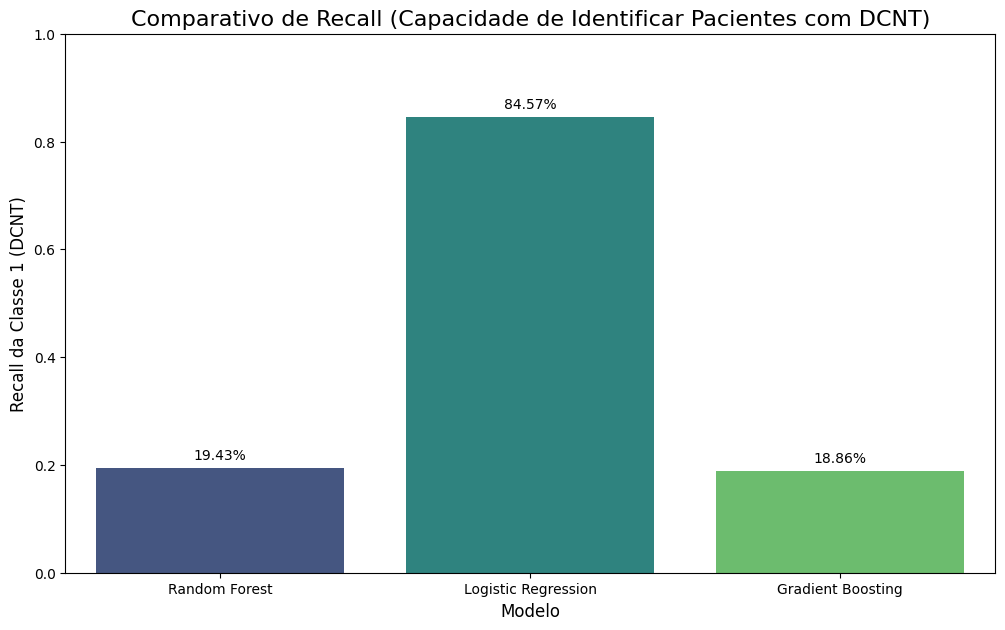

In [23]:
# Gráfico comparando o Recall, a métrica mais importante para este problema
plt.figure(figsize=(12, 7))
ax = sns.barplot(x='Modelo', y='Recall (classe 1)', data=df_resultados, palette='viridis')
plt.title('Comparativo de Recall (Capacidade de Identificar Pacientes com DCNT)', fontsize=16)
plt.ylabel('Recall da Classe 1 (DCNT)', fontsize=12)
plt.xlabel('Modelo', fontsize=12)
plt.ylim(0, 1.0) # Força o eixo Y a ir até 1.0 (100%)

# Adiciona os valores em cima das barras para clareza
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2%'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.show()

**Análise e Escolha do Modelo:** O gráfico demonstra claramente a superioridade do modelo de **Regressão Logística** para a tarefa de triagem. Com um **recall de 85%**, ele é capaz de identificar a grande maioria dos pacientes em risco, cumprindo o objetivo de não deixar casos potenciais passarem despercebidos. Em contraste, os modelos de Random Forest e Gradient Boosting, apesar de mais precisos quando acertam, falham em identificar mais de 80% dos casos. Portanto, a Regressão Logística foi o modelo escolhido para esta aplicação de negócio.

### Análise e Predição de Custo Evitado (Regressão)

A análise de custo evitado é um dos resultados de maior valor para o negócio. Para este projeto, foi construído um modelo preditivo para estimar a economia potencial ao incluir um paciente em um programa de cuidado.

**Metodologia e Correção Monetária:** Uma análise real e precisa do custo evitado exigiria o cálculo dos custos "antes vs. depois" da entrada do paciente em um programa, utilizando a data do primeiro diagnóstico como marco. É fundamental que, em uma implementação futura, os custos do período "antes" sejam ajustados pela **correção monetária**, utilizando um índice como o **IPCA (Índice Nacional de Preços ao Consumidor Amplo)**, para garantir uma comparação justa de valores ao longo do tempo.

**Resultados da Predição (Baseada em Simulação):** Para validar a viabilidade de um modelo preditivo, um Random Forest Regressor foi treinado com base em dados simulados. Os resultados foram excelentes:
- **R² (R-quadrado) de 0.80:** O modelo demonstrou uma forte capacidade preditiva, explicando 80% da variação no custo evitado.
- **MAE (Erro Médio Absoluto) de R$ 219.35:** O erro médio das previsões é baixo, indicando que o modelo é confiável para estimar a economia.